In [6]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Seed
random_state = 42

# Helper functions

Before diving in, we will define some helper functions that will automate some analysis and visualization

In [2]:
# Helper functions

def get_pct_target_by_feat(df, feat, label):
    feat_gpby = df.groupby([feat]).agg(label_cnt=(feat, 'count'),
                                       label_sum=(label, 'sum'))
    feat_gpby[f'% label by {feat}'] = round(feat_gpby['label_sum'] / feat_gpby['label_cnt'] * 100, 3)
    feat_gpby['% label total'] = round(feat_gpby['label_sum'] / df[label].sum() * 100, 3)
    feat_gpby['% population'] = round(feat_gpby['label_cnt'] / df.shape[0] * 100, 3)
    feat_gpby.sort_values(f'% label by {feat}', ascending=False, inplace=True)
    return feat_gpby

def plot_histogram(data, x, hue, bins="auto", log_scale=False):
    fig, ax = plt.subplots(figsize=(15, 8))
    sns.histplot(data=data, x=x, hue=hue, ax=ax, bins=bins, log_scale=log_scale);
    
def t_test(train_data, test_data, feat):
    from scipy.stats import ttest_ind
    ind_ttest = ttest_ind(train_data.loc[train_data[feat].notnull(), feat], 
                      test_data.loc[test_data[feat].notnull(), feat],
                      equal_var=True,
                      random_state=random_state)

    weltch_ttest = ttest_ind(train_data.loc[train_data[feat].notnull(), feat], 
                             test_data.loc[test_data[feat].notnull(), feat],
                             equal_var=False,
                             random_state=random_state)

    print(f"Independent sample t-test: pvalue {ind_ttest[1]}")
    print(f"Welch's two sample t-test: pvalue {weltch_ttest[1]}")

# Overview

The data that we will be working with came from the competition "Give me some credit" on Kaggle in 2012. 

In [3]:
# Load training and testing sets
train = pd.read_csv('data/cs-training.csv')
test = pd.read_csv('data/cs-test.csv')

In [4]:
train.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [28]:
test.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,NaN,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0
1,2,NaN,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0
2,3,NaN,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0
3,4,NaN,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0
4,5,NaN,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0


As we check for the data types in the training and testing sets, we can see that they follow the description of the dataset. The column names and data types in both the training and testing sets are also the same, and there are no incorrect data types that we will need to fix.

In [6]:
train.dtypes

Unnamed: 0                                int64
SeriousDlqin2yrs                          int64
RevolvingUtilizationOfUnsecuredLines    float64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
MonthlyIncome                           float64
NumberOfOpenCreditLinesAndLoans           int64
NumberOfTimes90DaysLate                   int64
NumberRealEstateLoansOrLines              int64
NumberOfTime60-89DaysPastDueNotWorse      int64
NumberOfDependents                      float64
dtype: object

In [7]:
test.dtypes

Unnamed: 0                                int64
SeriousDlqin2yrs                        float64
RevolvingUtilizationOfUnsecuredLines    float64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
MonthlyIncome                           float64
NumberOfOpenCreditLinesAndLoans           int64
NumberOfTimes90DaysLate                   int64
NumberRealEstateLoansOrLines              int64
NumberOfTime60-89DaysPastDueNotWorse      int64
NumberOfDependents                      float64
dtype: object

# Missing data

We will also quickly check for any missing data in our training set. There are only 2 columns with missing data (MonthlyIncome, NumberOfDependents): 
- MonthlyIncome has ~20% which can be considered high enough to drop the column. There are imputation methods that can also be utilized (replacement with mean/median, utilizing machine learning models to predict missing values, etc.), so we will leave it in the dataset for now.
- Meanwhile, NumberOfDependents has a lower % of missing data so we will also leverage the aforementioned methods to handle these missing values

In [14]:
for col in train.columns:
    null_count = train[col].isnull().sum()
    if null_count > 0:
        print(f'{col} null count: {null_count}, {round(null_count/train.shape[0]*100, 3)}%')

MonthlyIncome null count: 29731, 19.821%
NumberOfDependents null count: 3924, 2.616%


In [4]:
for col in train.columns:
    null_count = test[col].isnull().sum()
    if null_count > 0:
        print(f'{col} null count: {null_count}, {round(null_count/test.shape[0]*100, 3)}%')

SeriousDlqin2yrs null count: 101503, 100.0%
MonthlyIncome null count: 20103, 19.805%
NumberOfDependents null count: 2626, 2.587%


Next, we will perform a deep-dive analysis of the individual feature. The goal here is to:
- Generating insights: Insights are useful as the first step towards better understanding our data (i.e, comparing means of training and testing sets, observing distribution of our label relative to each feature, etc.)
- Missing/Incorrect data: Isolating records with Missing ("Null") data, Incorrect data (due to data entry errors, illogical data input by the customers, etc.)
- Check if we can distinguish our label based on any feature trends

# SeriousDlqin2yrs

In [22]:
train.SeriousDlqin2yrs.value_counts()

0    139974
1     10026
Name: SeriousDlqin2yrs, dtype: int64

In [24]:
test.SeriousDlqin2yrs.value_counts()

Series([], Name: SeriousDlqin2yrs, dtype: int64)

As we can see from the training dataset counts, there is an imbalance in the number of 1's and 0's of the label (Specifically, the ratio is ~ 13:1). As for the testing dataset, the label is hidden from us and we will need to submit to the competition to compute the accuracy of our model.

# RevolvingUtilizationOfUnsecuredLines

Revolving Utilization of Unsecured Lines is defined as "Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits". 

Based on the definition, a person with high revolving utilization (credit cards + personal lines of credit ~ credit limits) will borrow close to his credit limits (or in some cases as we will soon see, take on more personal lines to exceed the credit limit), thus he should have a harder time paying back his debts. 

As a result, we can test the hypothesis that people with a revolving utilization rate will be "riskier" (or have a higher probability of deliquency) compared to those with a lower utilization rate. In other words, revolving utilization should have a positive correlation with serious delinquency.

Looking at the distribution of both datasets, we can see that the majority of our dataset has a low revolving utilization rate (and that is a good thing!):
- 3% uses less than 3% of their credit limits
- 50% uses less than ~15% 
- And 75% uses less than ~56%

However, there are outliers on the right tail of our data, as we can see records with over 5,000,000%(!) in revolving utilization.

In [4]:
train.RevolvingUtilizationOfUnsecuredLines.describe()

count    150000.000000
mean          6.048438
std         249.755371
min           0.000000
25%           0.029867
50%           0.154181
75%           0.559046
max       50708.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64

In [6]:
test.RevolvingUtilizationOfUnsecuredLines.describe()

count    101503.000000
mean          5.310000
std         196.156039
min           0.000000
25%           0.030131
50%           0.152586
75%           0.564225
max       21821.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64

We can also use the 2 types of t-test (Independent and Weltch) to test the hypothesis that the training set and testing set have different means. The tests confirm that the 2 sets do not have different means.

In [16]:
t_test(train, test, 'RevolvingUtilizationOfUnsecuredLines')

Independent sample t-test: pvalue 0.4288231222445198
Welch's two sample t-test: pvalue 0.40754152477381234


Next we will look at the distribution of this feature relative to our label, and we will also divide the analysis in 2 seperate portions (<= 1 and > 1 revolving utilization) since the outliers on the right tail will make it difficult to visualize the combined data:

- The portions of data with <= 1 (~98%) utilization rate tell us that our hypothesis might be correct. People with no serious deliquency indeed seem to be more likely to have low revolving utilization of secured lines and vice versa.
- The portions of data with > 1 (~2%) utilization rate also paints a similar picture where 37% (1241/3338) people have serious delinquency. However, it is also worth noting that, the highest utilization of the training dataset was 5,000,000% and that record did not have delinquency, hence higher utilization does not always translate to serious delinquency.

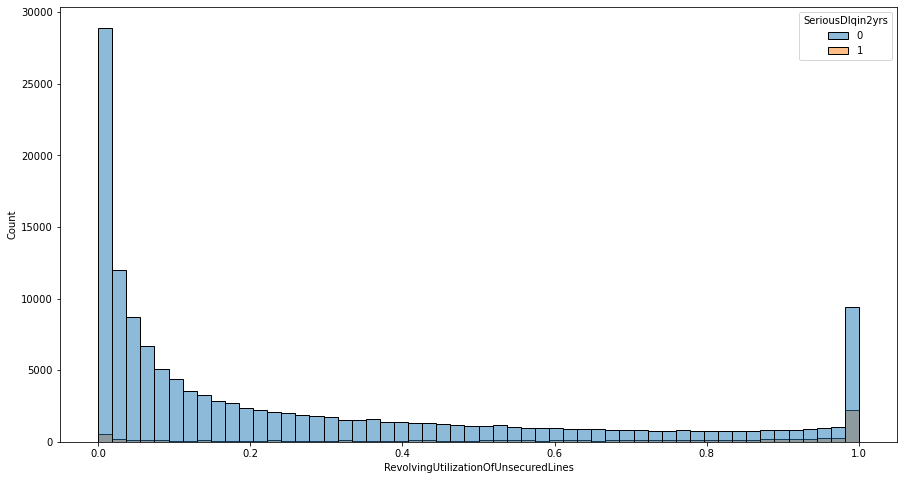

In [22]:
plot_histogram(data=train.loc[train.RevolvingUtilizationOfUnsecuredLines < 1],
               x='RevolvingUtilizationOfUnsecuredLines',
               hue='SeriousDlqin2yrs')

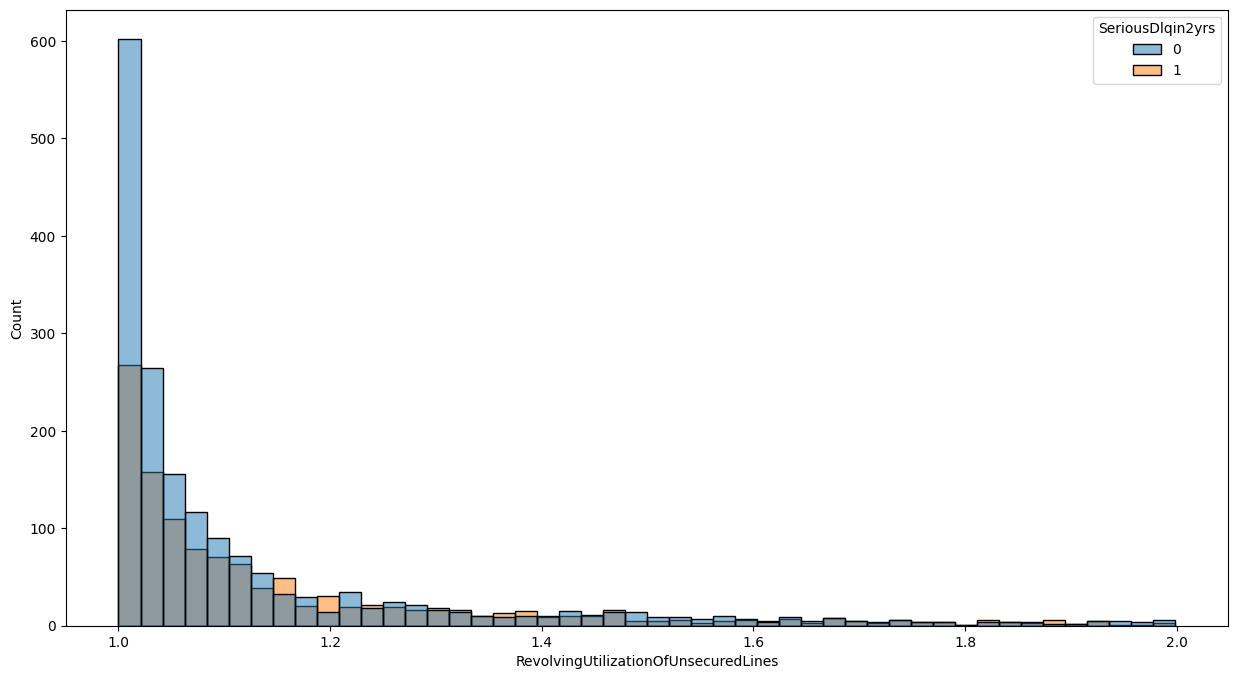

In [29]:
plot_histogram(data=train.loc[(train.RevolvingUtilizationOfUnsecuredLines >= 1)&
                              (train.RevolvingUtilizationOfUnsecuredLines <= 2)],
               x='RevolvingUtilizationOfUnsecuredLines',
               hue='SeriousDlqin2yrs')

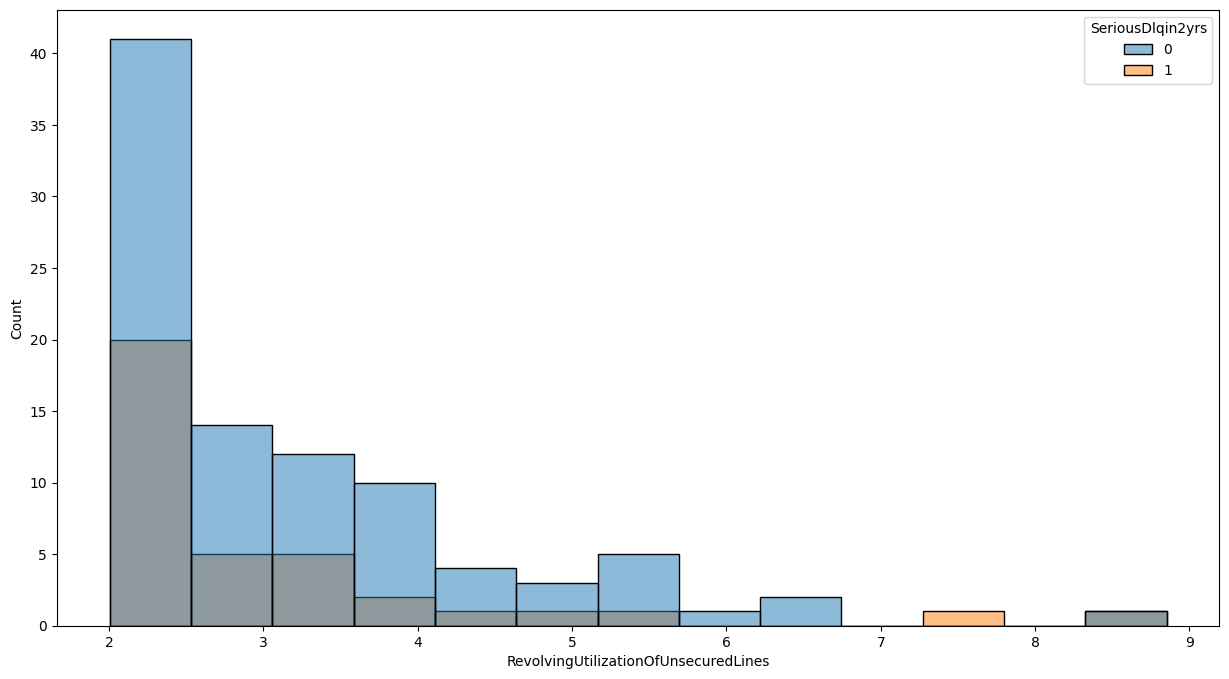

In [31]:
plot_histogram(data=train.loc[(train.RevolvingUtilizationOfUnsecuredLines > 2)&
                              (train.RevolvingUtilizationOfUnsecuredLines <= 10)],
               x='RevolvingUtilizationOfUnsecuredLines',
               hue='SeriousDlqin2yrs')

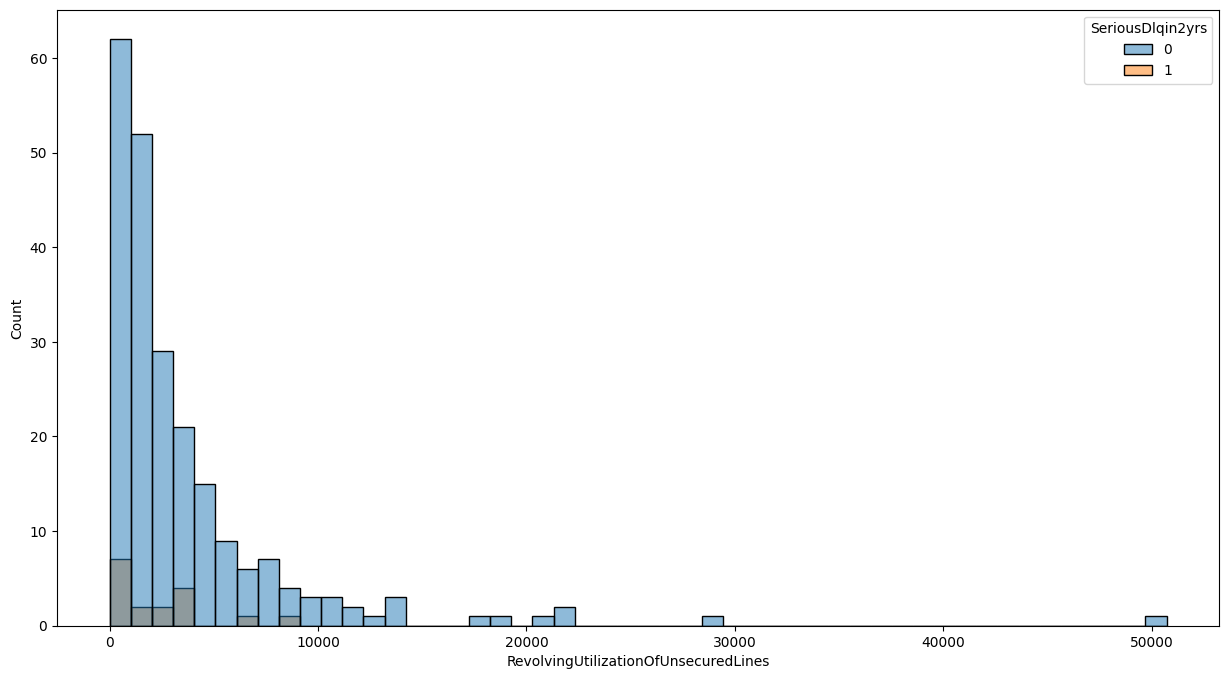

In [32]:
plot_histogram(data=train.loc[train.RevolvingUtilizationOfUnsecuredLines > 10],
               x='RevolvingUtilizationOfUnsecuredLines',
               hue='SeriousDlqin2yrs')

In [13]:
train.loc[(train.RevolvingUtilizationOfUnsecuredLines >= 1) &
          (train.SeriousDlqin2yrs == 0), 'RevolvingUtilizationOfUnsecuredLines'] \
     .describe(percentiles=[.25, .5, .75, .9])

count     2097.000000
mean       393.198902
std       2056.387995
min          1.000000
25%          1.016588
50%          1.067351
75%          1.368872
90%        122.400000
max      50708.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64

In [14]:
train.loc[(train.RevolvingUtilizationOfUnsecuredLines >= 1) &
          (train.SeriousDlqin2yrs == 1), 'RevolvingUtilizationOfUnsecuredLines'] \
     .describe(percentiles=[.25, .5, .75, .9])

count    1241.000000
mean       30.770538
std       373.791364
min         1.000000
25%         1.025948
50%         1.084165
75%         1.253651
90%         1.635910
max      8328.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64

Upon closer investigation, we can see that there are only 317 records in the training set and 245 in the testing set with more than 200% utilization rate. It is also interesting to note that the serious delinquency rate in this subset is even lower than the rest of the date at only ~17%. 

Since these outliers are so far away from the mean, our model will have a hard time learning and predicting them. We also cannot remove them from our dataset (we could have removed them if the outliers are only present in the training set), so we will need to consider other data cleaning/engineering options.

In [37]:
print('Number of records with abnormal utilization rate (>= 200%) in the training set: ' + 
      f'{train.loc[train.RevolvingUtilizationOfUnsecuredLines >= 2].shape[0]}')
print('Number of records with abnormal utilization rate (>= 200%) in the testing set: ' + 
      f'{test.loc[test.RevolvingUtilizationOfUnsecuredLines >= 2].shape[0]}')

Number of records with abnormal utilization rate (>= 200%) in the training set: 371
Number of records with abnormal utilization rate (>= 200%) in the testing set: 245


Count of No Dlq/Dlq for records with abnormal utilization rate:

In [39]:
train.loc[train.RevolvingUtilizationOfUnsecuredLines >= 2] \
     .groupby(['SeriousDlqin2yrs']).agg(count=('SeriousDlqin2yrs', 'count'))

,count
SeriousDlqin2yrs,
0,317
1,54


Finally, we can check the correlation between "RevolvingUtilizationOfUnsecuredLines" and our target. Even though it shows a weak negative correlation, we can still see a clear trend utilization rate vs. deliquency rate: consumers with less than 44.5% utilization rate only has 27% delinquency, while those with higher than 44.5% utilization rate has 83% deliquency .

In [41]:
train[['RevolvingUtilizationOfUnsecuredLines', 'SeriousDlqin2yrs']].corr()

,RevolvingUtilizationOfUnsecuredLines,SeriousDlqin2yrs
RevolvingUtilizationOfUnsecuredLines,1.000000,-0.001802
SeriousDlqin2yrs,-0.001802,1.000000


In [4]:
train['revol_util_bucket'] = pd.qcut(train['RevolvingUtilizationOfUnsecuredLines'], q=10)
train_revol_util_gpby = get_pct_target_by_feat(train, 'revol_util_bucket', 'SeriousDlqin2yrs')
train_revol_util_gpby.sort_values('revol_util_bucket', inplace=True)
train_revol_util_gpby

,label_cnt,label_sum,% label by revol_util_bucket,% label total,% population
revol_util_bucket,,,,,
"(-0.001, 0.00297]",15000,378,2.520,3.770,10.0
"(0.00297, 0.0192]",15000,204,1.360,2.035,10.0
"(0.0192, 0.0435]",15000,210,1.400,2.095,10.0
"(0.0435, 0.0832]",15000,287,1.913,2.863,10.0
"(0.0832, 0.154]",15000,356,2.373,3.551,10.0
"(0.154, 0.271]",15000,521,3.473,5.196,10.0
"(0.271, 0.445]",15000,787,5.247,7.850,10.0
"(0.445, 0.699]",15000,1320,8.800,13.166,10.0
"(0.699, 0.981]",15000,2488,16.587,24.815,10.0


### Key takeaways
- We can conclude the analysis of "RevolvingUtilizationOfUnsecuredLines" with the notion that people with a higher utilization rate have a higher probability of delinquency compared to people with a lower rate.
- However, the distribution by label tells us that we can not clearly distinguish customers with serious delinquent from customers without based on "RevolvingUtilizationOfUnsecuredLines"

# Age

Age is defined as the age of borrower in years. This feature may seem obvious at first, but actually it is not. First of all, we do not know if the dataset was collected all at once or at different time (i.e, if person whose age was 64 was collected in 2009 and another whose age was 30 was collected in 2010, there would be a discrepancy between the time of collection).

Looking at the distribution of both datasets, we can also see that most of our customer base is middle-aged to senior people, with 75% of customers are 41 or older and 25% of customers who are 63 or older. The training and testing also seem to have very similar distribution, as they have the same value at the 25th, 50th, and 75th percentile.

Next, we need to check for illogical data. We do not know the source of our data, but judging by the minimum value of age in the testing set, we can assume that it is 21. In the training set, there is only 1 record with age < 20 (and it is even 0!), which is not possible and we will need to fix this value.

In [18]:
train.age.describe()

count    150000.000000
mean         52.295207
std          14.771866
min           0.000000
25%          41.000000
50%          52.000000
75%          63.000000
max         109.000000
Name: age, dtype: float64

In [8]:
test.age.describe()

count    101503.000000
mean         52.405436
std          14.779756
min          21.000000
25%          41.000000
50%          52.000000
75%          63.000000
max         104.000000
Name: age, dtype: float64

We can also use the 2 types of t-test (Independent and Weltch) to test the hypothesis that the training set and testing set have different means. The tests confirm that the 2 sets do not have different means.

In [13]:
t_test(train, test, 'age')

Independent sample t-test: pvalue 0.0664150236751113
Welch's two sample t-test: pvalue 0.06644318457248334


In [10]:
train.loc[train.age <= 20, 'age'].value_counts()

0    1
Name: age, dtype: int64

Next, we will look at the distribution of age compared to our target and draw some analysis based on the distribution plot as well as a Top-k analysis by label:
- Over 80% of people who have a delinquent loan are between 20 and 60
- People between 23 and 33 have a high delinquency rate (i.e, 13% of 28-yo has serious delinquency)
- Despite the high rate (> 14%), people between 23 and 33 only account for 8% of the training set
- Overall, 65% of age value in the training set accounts for 83% of serious delinquency

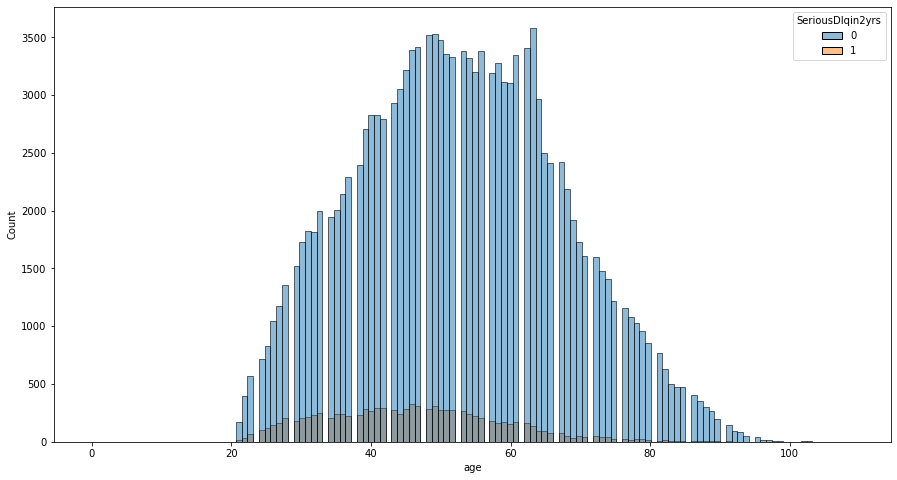

In [24]:
plot_histogram(data=train,
               x='age',
               hue='SeriousDlqin2yrs')

In [46]:
top_k = 20
train_age_gpby = get_pct_target_by_feat(train, 'age', 'SeriousDlqin2yrs')
print(f"Sum of % positive label for Top {top_k}: {str(train_age_gpby.iloc[:top_k].sum()['% label total'])}")
print(f"Sum of % population for Top {top_k}: {str(train_age_gpby.iloc[:top_k].sum()['% population'])}")
train_age_gpby.head(top_k)

Sum of % positive label for Top 20: 36.626
Sum of % population for Top 20: 23.314


,label_cnt,label_sum,% label by age,% label total,% population
age,,,,,
101,3,1,33.333,0.010,0.002
99,9,2,22.222,0.020,0.006
28,1560,205,13.141,2.045,1.040
25,953,121,12.697,1.207,0.635
27,1338,166,12.407,1.656,0.892
26,1193,147,12.322,1.466,0.795
24,816,98,12.010,0.977,0.544
32,2050,233,11.366,2.324,1.367
33,2239,246,10.987,2.454,1.493


On the other end of the distribution, we can see that the dataset has a particularly old population (as mentioned with over 25% of people who are 63 and older, and ~12% of people who are 70 and older). This part of the dataset also has a low delinquency rate, as the total delinquency rate of people who are 70 and older is less than 1%

In [52]:
print(f'% of indv. > 70 yo: {round(train.loc[train.age > 70].shape[0] / train.shape[0] * 100, 3)}')
print(f'% of indv. > 80 yo: {round(train.loc[train.age > 80].shape[0] / train.shape[0] * 100, 3)}')
print(f'% of indv. > 90 yo: {round(train.loc[train.age > 90].shape[0] / train.shape[0] * 100, 3)}')
print(f'% of indv. > 100 yo: {round(train.loc[train.age > 100].shape[0] / train.shape[0] * 100, 3)}')

% of indv. > 70 yo: 11.757
% of indv. > 80 yo: 3.291
% of indv. > 90 yo: 0.326
% of indv. > 100 yo: 0.009


In [53]:
train_age_gpby.tail(top_k)

,label_cnt,label_sum,% label by age,% label total,% population
age,,,,,
83,512,10,1.953,0.100,0.341
85,483,9,1.863,0.090,0.322
69,1954,35,1.791,0.349,1.303
75,1241,22,1.773,0.219,0.827
84,480,8,1.667,0.080,0.320
77,1099,18,1.638,0.180,0.733
90,198,3,1.515,0.030,0.132
86,407,6,1.474,0.060,0.271
81,774,9,1.163,0.090,0.516


Finally, we will check the Pearson correlation between "age" and our target, and we can see that there is indeed a negative correlation.

In [40]:
train[['age', 'SeriousDlqin2yrs']].corr()

,age,SeriousDlqin2yrs
age,1.000000,-0.115386
SeriousDlqin2yrs,-0.115386,1.000000


### Key takeaways 
- We can conclude the analysis of "Age" with the notion that younger people have a higher probability of delinquency compared to older people
- However, the distribution by label tells us that we can not clearly distinguish customers with serious delinquent from customers without based on "Age"

# Debt ratio

Debt ratio is defined as Monthly debt payments, alimony,living costs divided by monthy gross income. It is our intuition that a customer with a high debt ratio will be more likely to default on his loan and vice versa. 

It is also useful to note that since we have MonthlyIncome in our dataset, we can combine the 2 features to create a monthly debt payments feature.

Looking at the distribution of both datasets, we can see that the majority of our dataset has a low debt ratio:
- 25% has less than ~18% debt ratio
- 50% has less than ~37% debt ratio

However, we can see after the 75th percentile that our combined dataset has ~85% debt ratio. And same as the RevolvingUtilized gain there are outliers on the right tail of our data, as we can see records with over 30,000%(!) monthly debt to income ratio in the training set and over 77,000% monthly debt to income ratio in the testing set.

In [4]:
train.DebtRatio.describe(percentiles=[.25, .5, .75, .9])

count    150000.000000
mean        353.005076
std        2037.818523
min           0.000000
25%           0.175074
50%           0.366508
75%           0.868254
90%        1267.000000
max      329664.000000
Name: DebtRatio, dtype: float64

In [5]:
test.DebtRatio.describe(percentiles=[.25, .5, .75, .9])

count    101503.000000
mean        344.475020
std        1632.595231
min           0.000000
25%           0.173423
50%           0.364260
75%           0.851619
90%        1238.800000
max      268326.000000
Name: DebtRatio, dtype: float64

We can also use the 2 types of t-test (Independent and Weltch) to test the hypothesis that the training set and testing set have different means. The tests confirm that the 2 sets do not have different means.

In [20]:
t_test(train, test, 'DebtRatio')

Independent sample t-test: pvalue 0.26548172238591644
Welch's two sample t-test: pvalue 0.24548073756945765


Next we will look at the distribution of this feature relative to our label, and once again we will divide the analysis in 2 seperate portions (<= 100% and > 100% debt ratio) since the outliers on the right tail will make it difficult to visualize the combined data:

- The portions of the training set with <= 100% (~77%) debt ratio shows a few interesting things. First of all, it has 2 peaks: the first one at close to 0% and the second one at close to 30%. Secondly, we would have expected a positive correlation between DebtRatio and delinquency, but in reality delinquency has a smooth distribution relative to debt ratio.
- On the other hand, the portions of data with > 100% (~23%) debt ratio only has 1 peak close to 100% (the number of delinquency also focuses around this peak), and the larger values have a more uniform distribution.

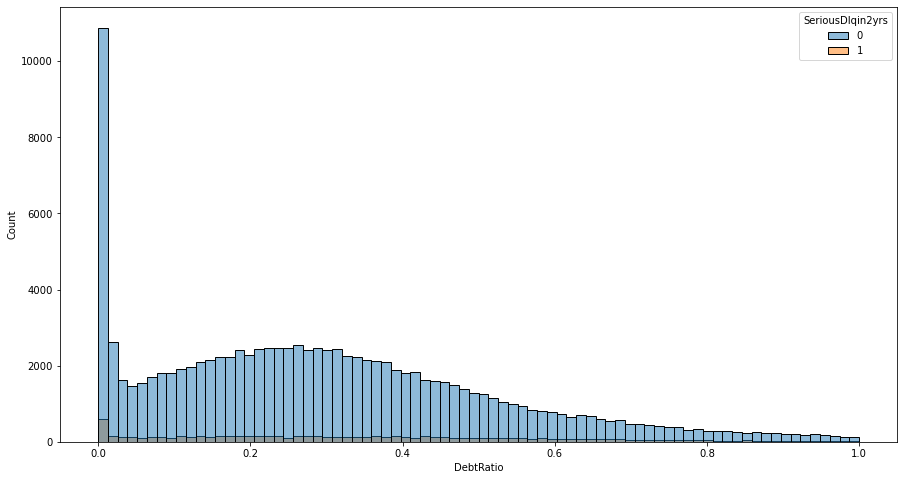

In [25]:
plot_histogram(data=train.loc[train.DebtRatio < 1],
               x='DebtRatio',
               hue='SeriousDlqin2yrs')

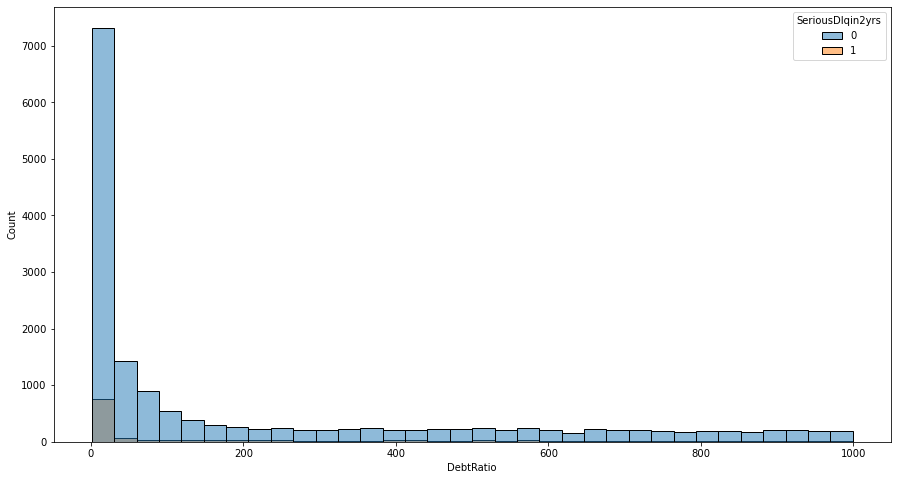

In [26]:
plot_histogram(data=train.loc[(train.DebtRatio > 1) & (train.DebtRatio < 1000)],
               x='DebtRatio',
               hue='SeriousDlqin2yrs')

Due to the skewness nature of DebtRatio, we can consider log transform this variable. After the transformation, we can observe that the distribution of the variable follows a more Gaussian one. However, we notice that the variable still has a slightly high concentration within the value range of 5-10.

C:\Users\Hieu Trieu\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


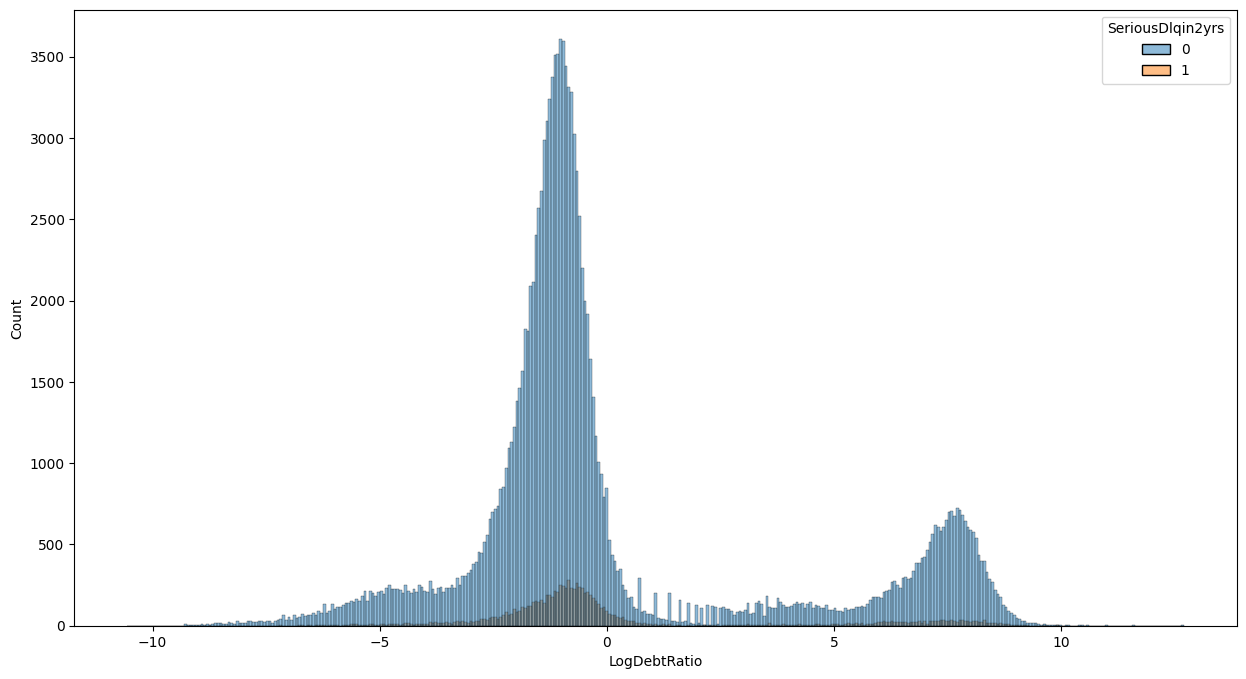

In [7]:
train['LogDebtRatio'] = np.log(train['DebtRatio'])
plot_histogram(data=train,
               x='LogDebtRatio',
               hue='SeriousDlqin2yrs')

Finally, we will check the Pearson correlation between "DebtRatio" and our target, and we can see that there is a small negative correlation. This is reflected in our analysis, where the distribution of deliquency focuses around the peaks of DebtRatio, which is mostly on lower values.

In [7]:
train[['DebtRatio', 'SeriousDlqin2yrs']].corr()

,DebtRatio,SeriousDlqin2yrs
DebtRatio,1.000000,-0.007602
SeriousDlqin2yrs,-0.007602,1.000000


### Key takeaway
- We can conclude the analysis of "age" with the notion that younger people have a higher probability of delinquency compared to older people.
- However, the distribution by label tells us that we can not clearly distinguish customers with serious delinquent from customers without based on "age"
- We will log transform the variable to make the variable follow a Gaussian distribution

# MonthlyIncome

MonthlyIncome is defined as the Monthly Income of a customer. We can hope that the more monthly income a customer has, the easier it will be for the customer to pay off his debts and thus have a lower probability of defaulting on loans.

In [8]:
train.MonthlyIncome.describe(percentiles=[.25, .5, .75, .9])

count    1.202690e+05
mean     6.670221e+03
std      1.438467e+04
min      0.000000e+00
25%      3.400000e+03
50%      5.400000e+03
75%      8.249000e+03
90%      1.166600e+04
max      3.008750e+06
Name: MonthlyIncome, dtype: float64

In [10]:
test.MonthlyIncome.describe(percentiles=[.25, .5, .75, .9])

count    8.140000e+04
mean     6.855036e+03
std      3.650860e+04
min      0.000000e+00
25%      3.408000e+03
50%      5.400000e+03
75%      8.200000e+03
90%      1.150000e+04
max      7.727000e+06
Name: MonthlyIncome, dtype: float64

We can also use the 2 types of t-test (Independent and Weltch) to test the hypothesis that the training set and testing set have different means. The tests confirm that the 2 sets do not have different means.

In [19]:
t_test(train, test, 'MonthlyIncome')

Independent sample t-test: pvalue 0.11334389454148659
Welch's two sample t-test: pvalue 0.1694732812622315


As we noted at the beginning, this feature has 20% missing data. We will first take a look at the distribution of other features based on 2 subsets (missing MonthlyIncome and not missing MonthlyIncome) to see if there is strange patterns.

Indeed, this subset of customers is older and have a significantly higher debt ratio compared to the rest of our dataset.

In [5]:
train.loc[train.MonthlyIncome.isnull()].describe()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,29731.000000,29731.000000,29731.000000,29731.000000,29731.000000,29731.000000,0.0,29731.000000,29731.000000,29731.000000,29731.000000,25807.000000
mean,74897.295786,0.056137,6.649421,56.362349,0.579866,1673.396556,NaN,7.216071,0.484612,0.871481,0.452995,0.316310
std,43364.172076,0.230189,217.814854,15.438786,6.255361,4248.372895,NaN,4.842720,6.250408,1.034291,6.242076,0.809944
min,7.000000,0.000000,0.000000,21.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
25%,36769.500000,0.000000,0.016027,46.000000,0.000000,123.000000,NaN,4.000000,0.000000,0.000000,0.000000,0.000000
50%,75111.000000,0.000000,0.081697,57.000000,0.000000,1159.000000,NaN,6.000000,0.000000,1.000000,0.000000,0.000000
75%,112544.500000,0.000000,0.440549,67.000000,0.000000,2382.000000,NaN,10.000000,0.000000,1.000000,0.000000,0.000000
max,149998.000000,1.000000,22198.000000,109.000000,98.000000,329664.000000,NaN,45.000000,98.000000,23.000000,98.000000,9.000000


In [6]:
train.loc[train.MonthlyIncome.notnull()].describe()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,120269.000000,120269.000000,120269.000000,120269.000000,120269.000000,120269.000000,1.202690e+05,120269.000000,120269.000000,120269.000000,120269.000000,120269.000000
mean,75026.012514,0.069486,5.899873,51.289792,0.381769,26.598777,6.670221e+03,8.758475,0.211925,1.054519,0.187829,0.851832
std,43286.029117,0.254280,257.040685,14.426684,3.499234,424.446457,1.438467e+04,5.172835,3.465276,1.149273,3.447901,1.148391
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37678.000000,0.000000,0.035084,40.000000,0.000000,0.143388,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,74969.000000,0.000000,0.177282,51.000000,0.000000,0.296023,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,112494.000000,0.000000,0.579428,61.000000,0.000000,0.482559,8.249000e+03,11.000000,0.000000,2.000000,0.000000,2.000000
max,150000.000000,1.000000,50708.000000,103.000000,98.000000,61106.500000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


Next we will look at the distribution of this feature relative to our label, and once again we will divide the analysis in 2 seperate portions (<= 10,000 and > 10,000 monthly income) since the outliers on the right tail will make it difficult to visualize the combined data.

- The portions of the training set with <= 10000 (~68%) monthly income shows a few interesting things. The data follows almost a Gaussian distribution, with most of the values focus around the middle area (highest peaks are around 4000, 5000, 6000). We can also see ~2000 records with close to 0 monthly income (turns out there are 2,245 records with less than 1000 monthly income). These records are highly suspecting as it is very unlikely for a customer to have 0 income and still be qualified for a loan, and it is also highly unlikely that a customer can have a single income of 1 or 2. 
- On the other hand, the portions of data with > 10000 (~32%) debt ratio only has 1 peak close to 100% (the number of delinquency also focuses around this peak), and the larger values have a more uniform distribution.

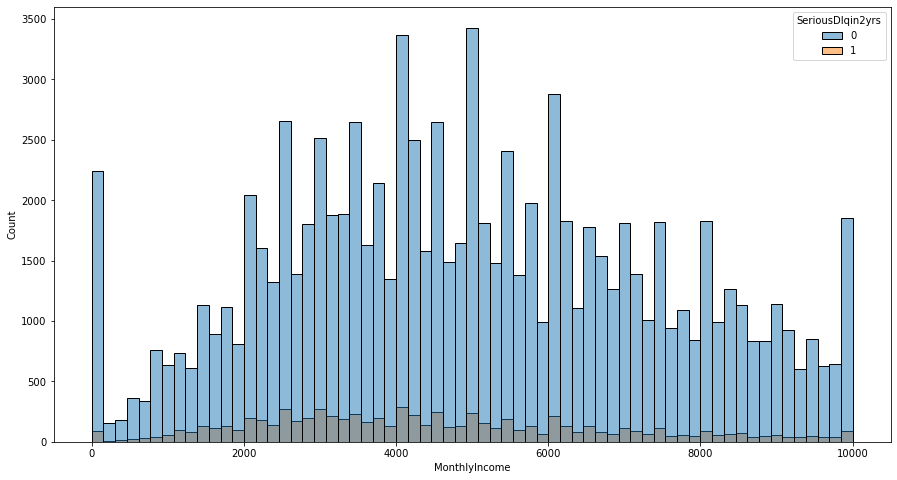

In [34]:
plot_histogram(data=train.loc[train.MonthlyIncome <= 10000],
               x='MonthlyIncome',
               hue='SeriousDlqin2yrs')

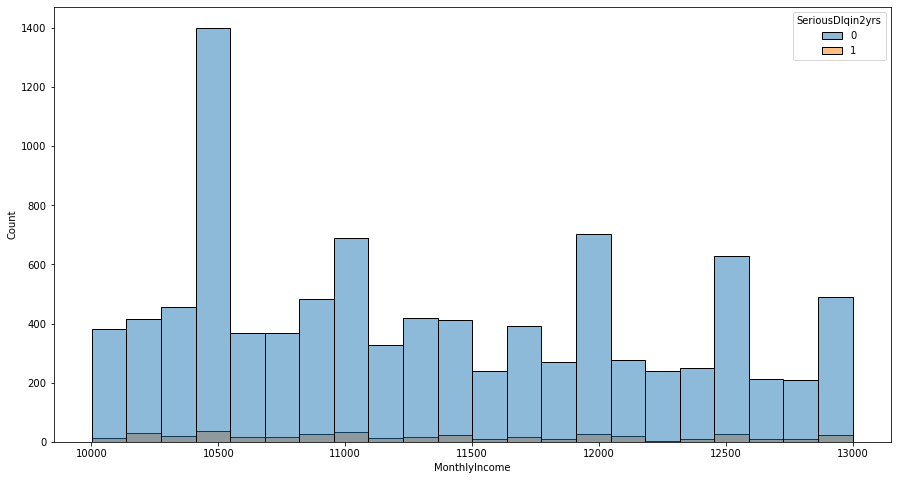

In [51]:
plot_histogram(data=train.loc[(train.MonthlyIncome > 10000) &
                              (train.MonthlyIncome <= 13000) ],
               x='MonthlyIncome',
               hue='SeriousDlqin2yrs')

In [4]:
train['mthly_inc_bucket'] = pd.qcut(train['MonthlyIncome'], q=10)
train_mthly_inc_gpby = get_pct_target_by_feat(train, 'mthly_inc_bucket', 'SeriousDlqin2yrs')
train_mthly_inc_gpby.sort_values('mthly_inc_bucket', inplace=True)
train_mthly_inc_gpby

,label_cnt,label_sum,% label by mthly_inc_bucket,% label total,% population
mthly_inc_bucket,,,,,
"(-0.001, 2005.0]",12028,1015,8.439,10.124,8.019
"(2005.0, 3000.0]",13056,1262,9.666,12.587,8.704
"(3000.0, 3800.0]",11322,1032,9.115,10.293,7.548
"(3800.0, 4544.2]",11702,947,8.093,9.445,7.801
"(4544.2, 5400.0]",12207,895,7.332,8.927,8.138
"(5400.0, 6300.0]",11850,792,6.684,7.899,7.900
"(6300.0, 7500.0]",12351,732,5.927,7.301,8.234
"(7500.0, 9083.0]",11733,600,5.114,5.984,7.822
"(9083.0, 11666.0]",12110,547,4.517,5.456,8.073


Finally, we will check the Pearson correlation between "MonthlyIncome" and our target, and we can see that there is a small negative correlation.

In [8]:
train[['MonthlyIncome', 'SeriousDlqin2yrs']].corr()

,MonthlyIncome,SeriousDlqin2yrs
MonthlyIncome,1.000000,-0.019746
SeriousDlqin2yrs,-0.019746,1.000000


### Key takeaways
- We can conclude the analysis of "MonthlyIncome" with the notion that customers with a higher income have a lower probability of delinquency compared to people with a lower income

# NumberOfOpenCreditLinesAndLoans

Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards). We can make an assumption that if a customer has a lot of credit lines and loans, his profile must be excellent to be able to qualify for those loans and as a result will be less likely to have delinquent loans.

In [45]:
train.NumberOfOpenCreditLinesAndLoans.describe(percentiles=[.25, .5, .75, .9])

count    150000.000000
mean          8.452760
std           5.145951
min           0.000000
25%           5.000000
50%           8.000000
75%          11.000000
90%          15.000000
max          58.000000
Name: NumberOfOpenCreditLinesAndLoans, dtype: float64

In [46]:
test.NumberOfOpenCreditLinesAndLoans.describe(percentiles=[.25, .5, .75, .9])

count    101503.000000
mean          8.453514
std           5.144100
min           0.000000
25%           5.000000
50%           8.000000
75%          11.000000
90%          15.000000
max          85.000000
Name: NumberOfOpenCreditLinesAndLoans, dtype: float64

We can also use the 2 types of t-test (Independent and Weltch) to test the hypothesis that the training set and testing set have different means. The tests confirm that the 2 sets do not have different means.

In [9]:
t_test(train, test, 'NumberOfOpenCreditLinesAndLoans')

Independent sample t-test: pvalue 0.9712492747074377
Welch's two sample t-test: pvalue 0.9712472857553139


Next, we will look at the distribution of NumberOfOpenCreditLinesAndLoans compared to our target and draw some analysis based on the distribution plot as well as a Top-k analysis by label:
- ~23% of people who have a delinquent loan have less than 3 open credit lines and loans
- 90% of the customers have equal or less 15 open credit lines and loans
- The highest value counts of open credit lines and loans are 6, 7, and 8 (all 3 have ~13,000 samples)
- There are outliers on the right tail of the data, with some records having up to more than 50 open credit lines and loans

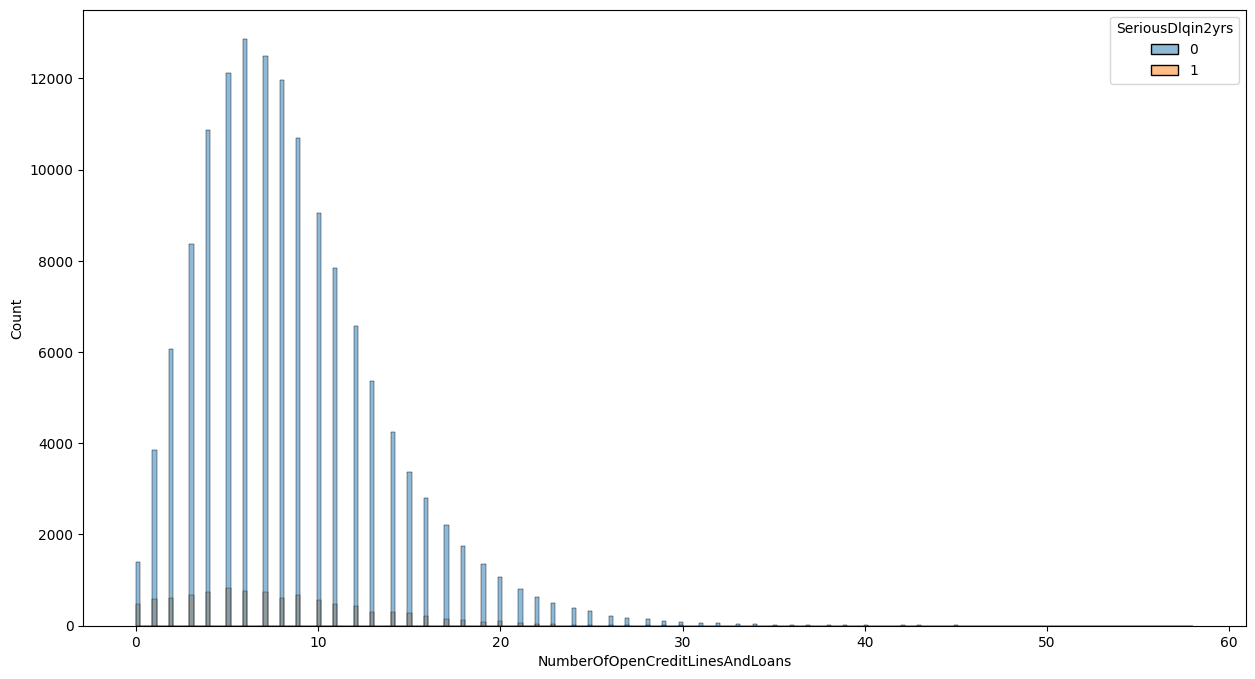

In [11]:
plot_histogram(data=train,
               x='NumberOfOpenCreditLinesAndLoans',
               hue='SeriousDlqin2yrs')

In [17]:
train['open_cred_bucket'] = pd.qcut(train['NumberOfOpenCreditLinesAndLoans'], q=6)
train_open_cred_gpby = get_pct_target_by_feat(train, 'open_cred_bucket', 'SeriousDlqin2yrs')
train_open_cred_gpby.sort_values('open_cred_bucket', inplace=True)
train_open_cred_gpby

,label_cnt,label_sum,% label by open_cred_bucket,% label total,% population
open_cred_bucket,,,,,
"(-0.001, 4.0]",33659,3103,9.219,30.950,22.439
"(4.0, 6.0]",26545,1573,5.926,15.689,17.697
"(6.0, 8.0]",25807,1353,5.243,13.495,17.205
"(8.0, 10.0]",20979,1238,5.901,12.348,13.986
"(10.0, 13.0]",20993,1222,5.821,12.188,13.995
"(13.0, 58.0]",22017,1537,6.981,15.330,14.678


In [18]:
train['NumberOfOpenCreditLinesAndLoans'].value_counts()

6     13614
7     13245
5     12931
8     12562
4     11609
9     11355
10     9624
3      9058
11     8321
12     7005
2      6666
13     5667
14     4546
1      4438
15     3645
16     3000
17     2370
0      1888
18     1874
19     1433
20     1169
21      864
22      685
23      533
24      422
25      337
26      239
27      194
28      150
29      114
30       88
31       74
32       52
33       47
34       35
35       27
36       18
38       13
40       10
39        9
42        8
45        8
43        8
37        7
48        6
49        4
54        4
41        4
52        3
46        3
57        2
51        2
56        2
47        2
50        2
44        2
58        1
53        1
Name: NumberOfOpenCreditLinesAndLoans, dtype: int64

Due to the skewness nature of NumberOfOpenCreditLinesAndLoans, we can consider log transform this variable. After the transformation, we can observe that the distribution of the variable follows a more Gaussian one.

C:\Users\Hieu Trieu\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


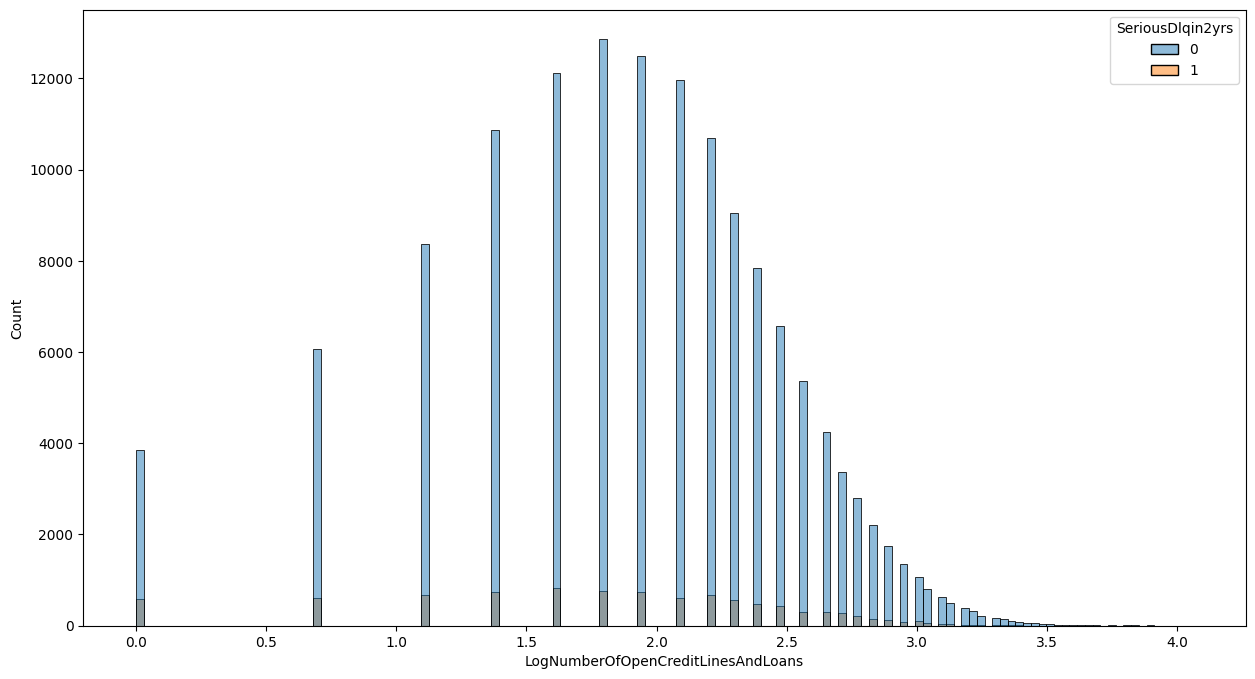

In [8]:
train['LogNumberOfOpenCreditLinesAndLoans'] = np.log(train['NumberOfOpenCreditLinesAndLoans'])
plot_histogram(data=train,
               x='LogNumberOfOpenCreditLinesAndLoans',
               hue='SeriousDlqin2yrs')

Finally, we will check the Pearson correlation between "NumberOfOpenCreditLinesAndLoans" and our target, and we can see that there is a small negative correlation.

In [10]:
train[['NumberOfOpenCreditLinesAndLoans', 'SeriousDlqin2yrs']].corr()

,NumberOfOpenCreditLinesAndLoans,SeriousDlqin2yrs
NumberOfOpenCreditLinesAndLoans,1.000000,-0.029669
SeriousDlqin2yrs,-0.029669,1.000000


### Key takeaways
- We can conclude the analysis of "NumberOfOpenCreditLinesAndLoans" with the notion that customers with a lower number of credit lines and loans have a higher probability of delinquency
- However, the distribution by label tells us that we can not clearly distinguish customers with serious delinquent from customers without based on "NumberOfOpenCreditLinesAndLoans"
- We will log transform the variable to make the variable follow a Gaussian distribution

# NumberRealEstateLoansOrLines

NumberRealEstateLoansOrLines is defined as the number of mortgage and real estate loans including home equity lines of credit. Compared to the number of open credit lines and loans above, real estate loans are harder to acquire due to the sheer size of the asset (a mortgage for a house will typically have a larger payment amount than say a car loan or a personal loan). Indeed, we can see that besides the outliers, the distribution of real estate loans have lower values (90% of the dataset have less than or equal to 2 loans).

In [5]:
train.NumberRealEstateLoansOrLines.describe(percentiles=[.25, .5, .75, .9])

count    150000.000000
mean          1.018240
std           1.129771
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
90%           2.000000
max          54.000000
Name: NumberRealEstateLoansOrLines, dtype: float64

In [6]:
test.NumberRealEstateLoansOrLines.describe(percentiles=[.25, .5, .75, .9])

count    101503.000000
mean          1.013074
std           1.110253
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
90%           2.000000
max          37.000000
Name: NumberRealEstateLoansOrLines, dtype: float64

Next, we will look at the distribution of NumberRealEstateLoansOrLines compared to our target and draw some analysis based on the distribution plot as well as a Top-k analysis by label:
- ~47% of people who have a delinquent loan do not have any open real estates loans or credit lines 
- ~83% of our training dataset have equal or less than 2 open real estates loans or credit lines, and of this subset ~91% have a delinquent loan
- There are outliers on the right tail of the data, with some records having up to more than 50 real estates loans or credit lines

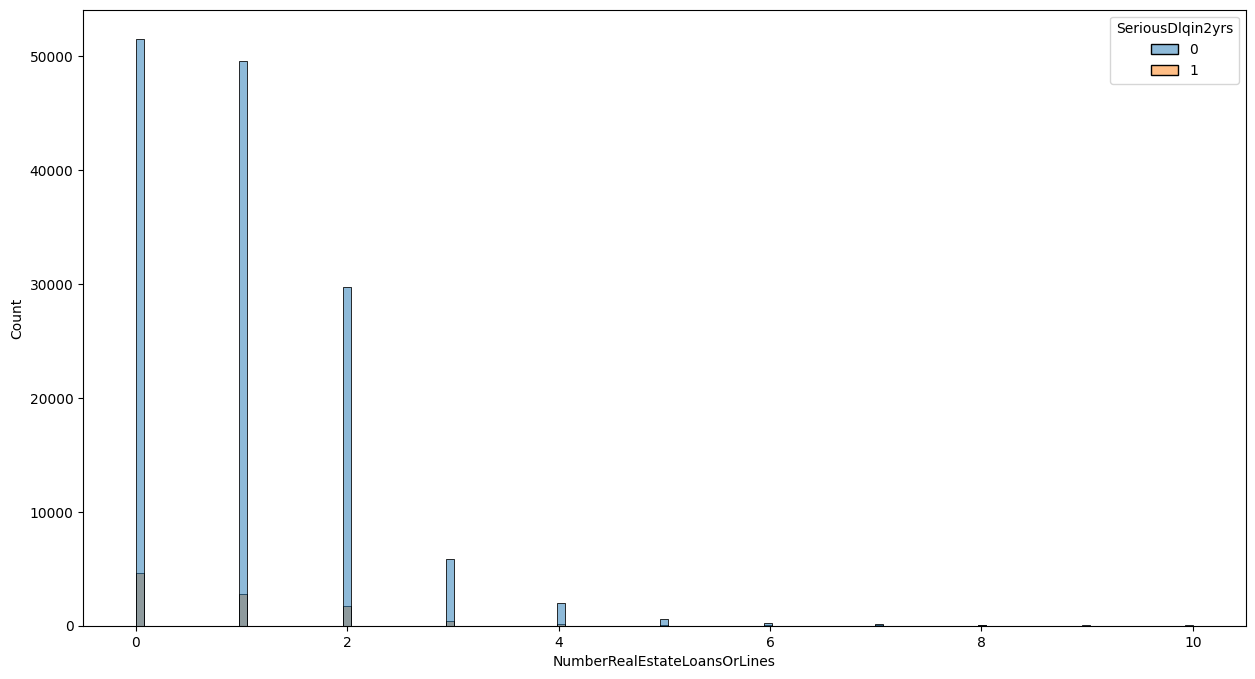

In [20]:
plot_histogram(data=train.loc[train['NumberRealEstateLoansOrLines'] <= 10],
               x='NumberRealEstateLoansOrLines',
               hue='SeriousDlqin2yrs')

In [6]:
train_re_loan_gpby = get_pct_target_by_feat(train, 'NumberRealEstateLoansOrLines', 'SeriousDlqin2yrs')
train_re_loan_gpby.sort_values('NumberRealEstateLoansOrLines', inplace=True)
train_re_loan_gpby

,label_cnt,label_sum,% label by NumberRealEstateLoansOrLines,% label total,% population
NumberRealEstateLoansOrLines,,,,,
0,56188,4672,8.315,46.599,37.459
1,52338,2748,5.250,27.409,34.892
2,31522,1765,5.599,17.604,21.015
3,6300,422,6.698,4.209,4.200
4,2170,194,8.940,1.935,1.447
5,689,83,12.046,0.828,0.459
6,320,48,15.000,0.479,0.213
7,171,31,18.129,0.309,0.114
8,93,23,24.731,0.229,0.062


Finally, we will check the Pearson correlation between "NumberRealEstateLoansOrLines" and our target, and we can see that there is a small negative correlation. This is reflected in our analysis, where the majority of deliquency focuses on the lower values of NumberRealEstateLoansOrLines.

In [79]:
train[['NumberRealEstateLoansOrLines', 'SeriousDlqin2yrs']].corr()

,NumberRealEstateLoansOrLines,SeriousDlqin2yrs
NumberRealEstateLoansOrLines,1.000000,-0.007038
SeriousDlqin2yrs,-0.007038,1.000000


### Key takeaways
- We can conclude the analysis of "NumberRealEstateLoansOrLines" with the notion that people with a lower number of real estate loans or credit lines have a lower probability of delinquency
- The lower values of real estate loans (equal or less than 2) has the majority of the number of delinquent customers

# NumberOfDependents

NumberOfDependents is defined as the Number of dependents in family excluding themselves (spouse, children etc.). We can make an assumption that the higher the number of dependents a customer has, the harder it is for that customer to make payments on his loan (since he has to take care of his dependents first before considering paying off loans).

In [10]:
train['NumberOfDependents'].describe(percentiles=[.25, .5, .75, .9])

count    146076.000000
mean          0.757222
std           1.115086
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
90%           2.000000
max          20.000000
Name: NumberOfDependents, dtype: float64

In [11]:
test['NumberOfDependents'].describe(percentiles=[.25, .5, .75, .9])

count    98877.000000
mean         0.769046
std          1.136778
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
90%          2.000000
max         43.000000
Name: NumberOfDependents, dtype: float64

Next, we will look at the distribution of NumberOfDependents compared to our target and draw some analysis based on the distribution plot as well as a Top-k analysis by label:
- ~58% of the customers have 0 dependents, which is interesting since the average age of this subset is 54
- 90% of the customers have equal or less 2 dependents, and ~85% of this customers subset has a delinquent loan
- There are outliers on the right tail of the data, with some records having up to more than 8 dependents!

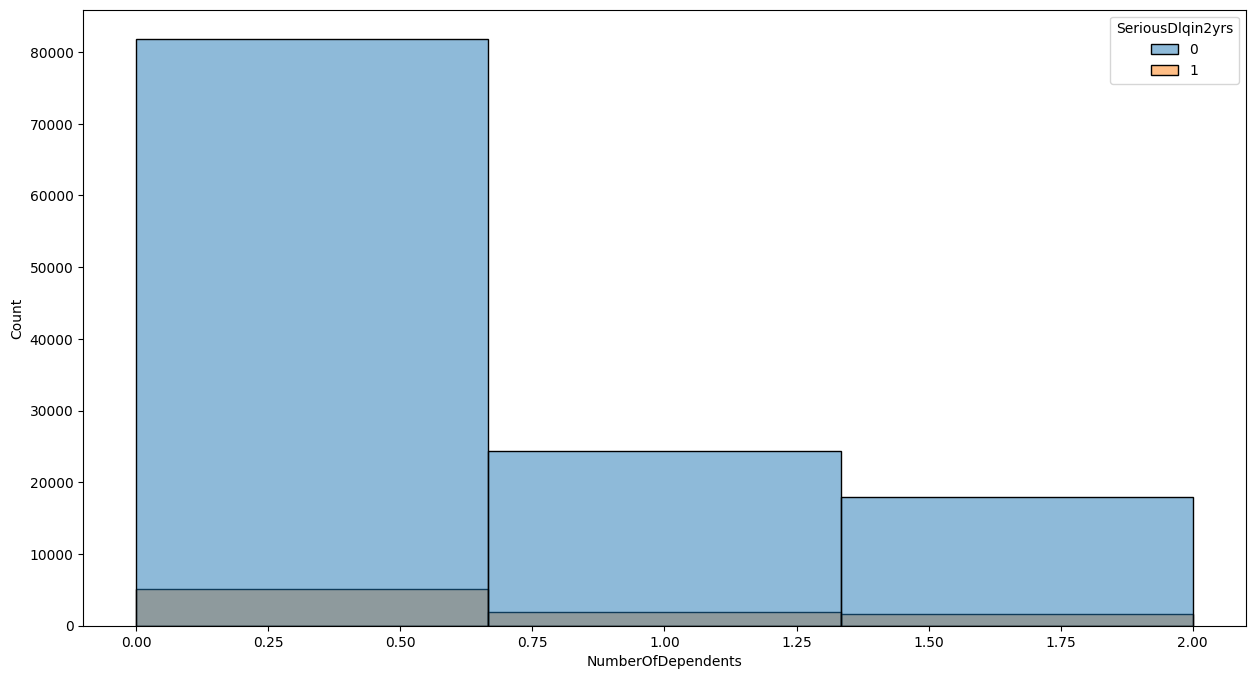

In [9]:
plot_histogram(data=train.loc[train['NumberOfDependents'] <= 2],
               x='NumberOfDependents',
               hue='SeriousDlqin2yrs', bins=3)

In [21]:
get_pct_target_by_feat(train, 'NumberOfDependents', 'SeriousDlqin2yrs').sort_index()

,label_cnt,label_sum,% label by NumberOfDependents,% label total,% population
NumberOfDependents,,,,,
0.0,86902,5095,5.863,50.818,57.935
1.0,26316,1935,7.353,19.300,17.544
2.0,19522,1584,8.114,15.799,13.015
3.0,9483,837,8.826,8.348,6.322
4.0,2862,297,10.377,2.962,1.908
5.0,746,68,9.115,0.678,0.497
6.0,158,24,15.190,0.239,0.105
7.0,51,5,9.804,0.050,0.034
8.0,24,2,8.333,0.020,0.016


In [19]:
train.loc[train['NumberOfDependents']==0].describe()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,86902.000000,86902.000000,86902.000000,86902.000000,86902.000000,86902.000000,6.545600e+04,86902.000000,86902.000000,86902.000000,86902.000000,86902.0
mean,75054.386159,0.058629,5.666405,54.396642,0.423247,418.946560,5.873411e+03,8.158052,0.291892,0.905641,0.268038,0.0
std,43303.577380,0.234931,263.043010,16.091790,4.587563,2091.654324,1.054586e+04,5.184115,4.571026,1.112255,4.559327,0.0
min,3.000000,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0
25%,37512.000000,0.000000,0.023051,42.000000,0.000000,0.149640,3.000000e+03,4.000000,0.000000,0.000000,0.000000,0.0
50%,75166.500000,0.000000,0.118846,56.000000,0.000000,0.372411,4.783000e+03,7.000000,0.000000,1.000000,0.000000,0.0
75%,112537.750000,0.000000,0.505089,66.000000,0.000000,2.911055,7.400000e+03,11.000000,0.000000,1.000000,0.000000,0.0
max,150000.000000,1.000000,50708.000000,107.000000,98.000000,329664.000000,1.794060e+06,58.000000,98.000000,54.000000,98.000000,0.0


Due to the skewness nature of NumberOfDependents, we can consider log transform this variable. However, we can observe after the transformation that the distribution of the variable does not follow a more Gaussian distribution. Therefore we will not transform this variable.

C:\Users\Hieu Trieu\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


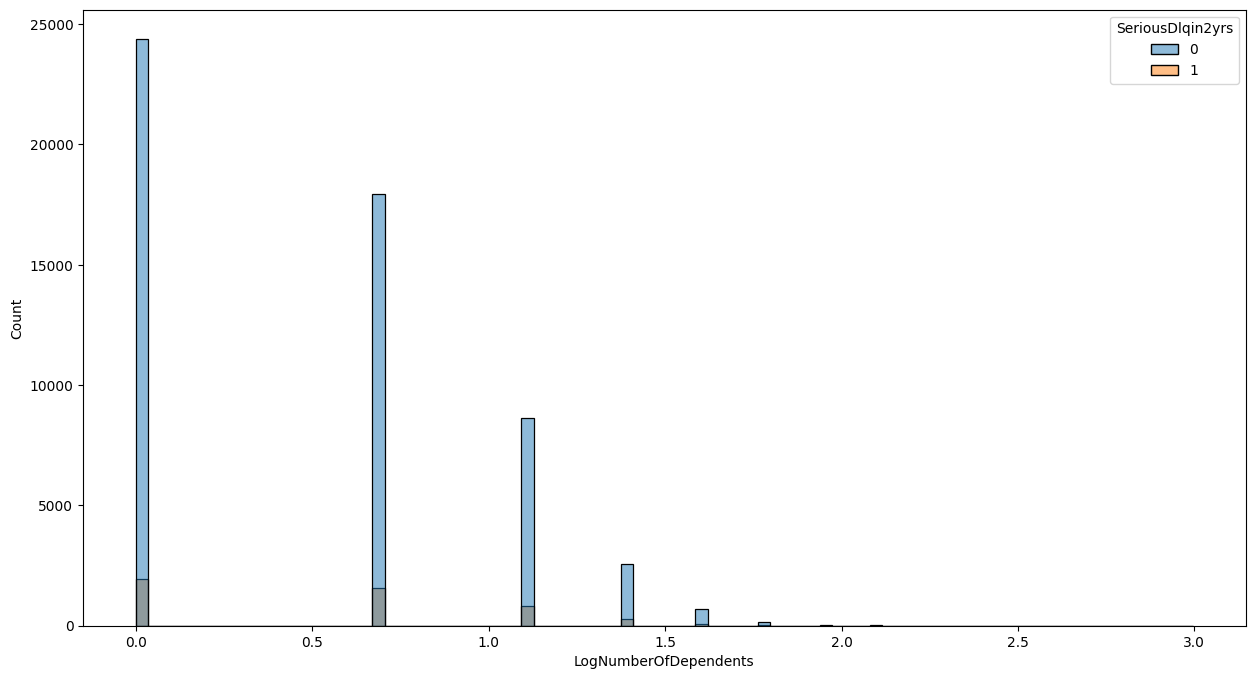

In [9]:
train['LogNumberOfDependents'] = np.log(train['NumberOfDependents'])
plot_histogram(data=train,
               x='LogNumberOfDependents',
               hue='SeriousDlqin2yrs')

Finally, we will check the Pearson correlation between "NumberOfDependents" and our target, and we can see that there is a positive correlation.

In [77]:
train[['NumberOfDependents', 'SeriousDlqin2yrs']].corr()

,NumberOfDependents,SeriousDlqin2yrs
NumberOfDependents,1.000000,0.046048
SeriousDlqin2yrs,0.046048,1.000000


### Key takeaways
- We can conclude the analysis of "NumberOfDependents" with the notion that customers with a higher number of dependents have a higher probability of delinquency
- However, the distribution by label tells us that we can not clearly distinguish customers with serious delinquent from customers without based on "NumberOfDependents"

# NumberOfTime30-59DaysPastDueNotWorse

Number Of Time 30-59 Days Past Due Not Worse is defined as "Number of times borrower has been 30-59 days past due but no worse in the last 2 years". In the financial and banking industry (specifically in Vietnam), loans are classified into the following groups:
- Group 1: Days past due (DPD) < 10 days
- Group 2: 10 days <= DPD < 30 days
- Group 3: 30 days <= DPD < 90 days
- Group 4: 90 days <= DPD < 180 days
- Group 5: 180 days < DPD (Delinquency)

Loan group 4 and 5 are considered as bad debt, with Group 5 as being delinquent. As a result, we can consider records with a high number of 'NumberOfTime30-59DaysPastDueNotWorse' to be struggling with paying off debts. 

Furthermore, it is worth noting that for every record, the person has to pay off his debt for the DPD to reset back to 0. Therefore:
- A customer with a lower number of times with 30-59 DPD means either he rarely has troubles paying off his debts, or another customer only fails to pay off his debt once, but he never made another payment thereafter. Both cases could have a low NumberOfTime30-59DaysPastDueNotWorse, but the latter will have a deliquent loan as his debt climbs to 180 DPD. 
- A customer with a high count of 30-59DPD can have a scenario that he misses his payments by at least 1-2 months, pays back, and then misses the next payment again. 

We will analyze the behavior (correlation between number of 30-59 DPD and Serious Deliquency) of these 2 groups of customers to understand our data better.

Looking at the distribution of this feature, we can see that the majority of our dataset (including training and testing sets) do not have any past due debts (with 84% have 0 times, and 97% have equal or less than 2 times of having 30-59DPD). However, it is also interesting to see that this 97% of the dataset also has 74% of people with serious delinquency, which matches our assessment above. 

In [38]:
train_30_59_dpd_gpby = get_pct_target_by_feat(train, 'NumberOfTime30-59DaysPastDueNotWorse', 'SeriousDlqin2yrs')
train_30_59_dpd_gpby.sort_values(['% population'], ascending=False, inplace=True)
train_30_59_dpd_gpby

,label_cnt,label_sum,% label by NumberOfTime30-59DaysPastDueNotWorse,% label total,% population
NumberOfTime30-59DaysPastDueNotWorse,,,,,
0,126018,5041,4.000,50.279,84.012
1,16033,2409,15.025,24.028,10.689
2,4598,1219,26.512,12.158,3.065
3,1754,618,35.234,6.164,1.169
4,747,318,42.570,3.172,0.498
5,342,154,45.029,1.536,0.228
98,264,143,54.167,1.426,0.176
6,140,74,52.857,0.738,0.093
7,54,28,51.852,0.279,0.036


In [37]:
test_30_59_dpd_gpby = get_pct_target_by_feat(test, 'NumberOfTime30-59DaysPastDueNotWorse', 'SeriousDlqin2yrs')
test_30_59_dpd_gpby.sort_values(['% population'], ascending=False, inplace=True)
test_30_59_dpd_gpby

,label_cnt,label_sum,% label by NumberOfTime30-59DaysPastDueNotWorse,% label total,% population
NumberOfTime30-59DaysPastDueNotWorse,,,,,
0,85190,0.0,0.0,NaN,83.929
1,10837,0.0,0.0,NaN,10.677
2,3168,0.0,0.0,NaN,3.121
3,1201,0.0,0.0,NaN,1.183
4,510,0.0,0.0,NaN,0.502
98,213,0.0,0.0,NaN,0.210
5,205,0.0,0.0,NaN,0.202
6,88,0.0,0.0,NaN,0.087
7,42,0.0,0.0,NaN,0.041


Furthermore, we can see that there are 2 abnormal values in this dataset, which are 96 and 98. If we assume that a customer only has 1 loan, in order to accumulate 96 times of 30-59DPD, it would take 48 months(or 4 years). Checking with the "NumberOfNumberOfTimes90DaysLate" feature, again we see something strange: 100% of these customers (both in the training and test set) have the same number of times where they have 60-89DPD and 90 DPD. This is somewhat extreme, as a normal borrower can make delayed payments but will try to pay before the 90th day mark. 

These customers also have a very high rate of delinquent loans (as we can observe in the table above): 54% of customers with 98 times of 30-59DPD have a delinquent loan, and 80% of customers with 96 times of 30-59DPD have a delinquent loan.

In [28]:
abnormal_30_59_dpd_train = train.loc[train['NumberOfTime30-59DaysPastDueNotWorse'].isin([96, 98])]
abnormal_30_59_dpd_test = test.loc[test['NumberOfTime30-59DaysPastDueNotWorse'].isin([96, 98])]

print(f"% of customers who has 30-59DPD and 60-89DPD in the training set that also has the same number of 90DPD: ")
print(abnormal_30_59_dpd_train.loc[abnormal_30_59_dpd_train['NumberOfTime30-59DaysPastDueNotWorse'] == abnormal_30_59_dpd_train['NumberOfTimes90DaysLate'], 
                             ['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate']].value_counts())
print('\n')
print(f"% of customers who has 30-59DPD and 60-89DPD in the testing set that also has the same number of 90DPD: ")
print(abnormal_30_59_dpd_test.loc[abnormal_30_59_dpd_test['NumberOfTime30-59DaysPastDueNotWorse'] == abnormal_30_59_dpd_test['NumberOfTimes90DaysLate'], 
                             ['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate']].value_counts())

% of customers who has 30-59DPD and 60-89DPD in the training set that also has the same number of 90DPD: 
NumberOfTime30-59DaysPastDueNotWorse  NumberOfTime60-89DaysPastDueNotWorse  NumberOfTimes90DaysLate
98                                    98                                    98                         264
96                                    96                                    96                           5
dtype: int64


% of customers who has 30-59DPD and 60-89DPD in the testing set that also has the same number of 90DPD: 
NumberOfTime30-59DaysPastDueNotWorse  NumberOfTime60-89DaysPastDueNotWorse  NumberOfTimes90DaysLate
98                                    98                                    98                         213
96                                    96                                    96                           1
dtype: int64


While we are checking records with the same number of times across 3 columns of 30-59DPD, 60-89DPD, and 90DPD, we can also look at the rest of the values besides 96 and 98. Again, we see the same phenomenon: ~80% of our data (119,930/150,000) have the same value across all 3 columns (30-59DPD, 60-89DPD, 90DPD).

Indeed, we can see that customers with 0 in all 3 columns have a very low rate of delinquency (~3%), while customers with non 0 in all 3 columns have a high rate of delinquency: 39% of customers with 1 time(s), 47% of customers with 2 time(s), and 100% of customers with 3 and 5 time(s). This confirms our assumption earlier that customers that either missing payments a lot of times or only missing payments a few times but these instances last a long time are very likely to have delinquent loans.

In [5]:
train.loc[~train['NumberOfTime30-59DaysPastDueNotWorse'].isin([96, 98]) &
          (train['NumberOfTime30-59DaysPastDueNotWorse'] == train['NumberOfTime60-89DaysPastDueNotWorse']) &
          (train['NumberOfTimes90DaysLate'] == train['NumberOfTime60-89DaysPastDueNotWorse'])].shape

(119930, 12)

In [6]:
train.loc[~train['NumberOfTime30-59DaysPastDueNotWorse'].isin([96, 98]) &
          (train['NumberOfTime30-59DaysPastDueNotWorse'] == train['NumberOfTime60-89DaysPastDueNotWorse']) &
          (train['NumberOfTimes90DaysLate'] == train['NumberOfTime60-89DaysPastDueNotWorse']),
          ['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate', 'SeriousDlqin2yrs']].value_counts()

NumberOfTime30-59DaysPastDueNotWorse  NumberOfTime60-89DaysPastDueNotWorse  NumberOfTimes90DaysLate  SeriousDlqin2yrs
0                                     0                                     0                        0                   116373
                                                                                                     1                     3264
1                                     1                                     1                        0                      156
                                                                                                     1                      100
2                                     2                                     2                        1                       16
                                                                                                     0                       14
3                                     3                                     3                        1            

At the same time, we can also investigate customers with different individual values of the 3 groups of DPD. We can also check if there are any illogical values (number of times 90DPD > number of times 60-89DPD > numbers of times 30-59DPD). This is because a customer has to have a loan past 30-59DPD before that loan can reach 90DPD, which means the number of times 30-59DPD must always be greater than number of times 60-89DPD, and the number of times 60-89DPD must always be greater than the number of times 90DPD.

Interestingly, we have discovered that there are in the training set :
- 3,769 records that have the number of times 30-59DPD < number of times 60-89DPD
- 4,997 records that have the number of times 30-59DPD < number of times 90DPD
- 6,452 records that have the number of times 60-89DPD < number of times 90DPD

We will try to correct these values before training our ML models. 

In [18]:
train.loc[(train['NumberOfTime30-59DaysPastDueNotWorse'] < train['NumberOfTime60-89DaysPastDueNotWorse']), 
          ['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse']].value_counts()

NumberOfTime30-59DaysPastDueNotWorse  NumberOfTime60-89DaysPastDueNotWorse
0                                     1                                       2768
                                      2                                        333
1                                     2                                        306
                                      3                                         85
0                                     3                                         78
2                                     3                                         62
1                                     4                                         24
2                                     4                                         22
3                                     4                                         21
0                                     4                                         17
1                                     5                                         15
0           

In [19]:
train.loc[(train['NumberOfTime30-59DaysPastDueNotWorse'] < train['NumberOfTimes90DaysLate']), 
          ['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTimes90DaysLate']].value_counts()

NumberOfTime30-59DaysPastDueNotWorse  NumberOfTimes90DaysLate
0                                     1                          2775
                                      2                           708
1                                     2                           383
0                                     3                           257
1                                     3                           195
0                                     4                           113
2                                     3                           108
1                                     4                            99
0                                     5                            57
1                                     5                            40
2                                     4                            36
0                                     6                            33
3                                     4                            20
1                           

In [20]:
train.loc[(train['NumberOfTime60-89DaysPastDueNotWorse'] < train['NumberOfTimes90DaysLate']), 
          ['NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate']].value_counts()

NumberOfTime60-89DaysPastDueNotWorse  NumberOfTimes90DaysLate
0                                     1                          3909
                                      2                           944
1                                     2                           389
0                                     3                           383
1                                     3                           172
0                                     4                           151
1                                     4                            89
0                                     5                            68
2                                     3                            64
0                                     6                            37
1                                     5                            35
2                                     4                            31
1                                     6                            23
0                           

We can also use the 2 types of t-test (Independent and Weltch) to test the hypothesis that the training set and testing set have different means. The tests confirm that the 2 sets do not have different means.

In [21]:
t_test(train, test, 'NumberOfTime30-59DaysPastDueNotWorse')

Independent sample t-test: pvalue 0.06320135256958599
Welch's two sample t-test: pvalue 0.06730079206153378


Finally, we will check the Pearson correlation between "NumberOfTime30-59DaysPastDueNotWorse" and our target, and we can see that there is indeed a positive correlation.

In [39]:
train[['NumberOfTime30-59DaysPastDueNotWorse', 'SeriousDlqin2yrs']].corr()

,NumberOfTime30-59DaysPastDueNotWorse,SeriousDlqin2yrs
NumberOfTime30-59DaysPastDueNotWorse,1.000000,0.125587
SeriousDlqin2yrs,0.125587,1.000000


### Key takeaways 
- We can conclude the analysis of "NumberOfTime30-59DaysPastDueNotWorse" with the notion that the more times a customer has missed payments with 30-59DPD, the higher chance the loan will become delinquent.

# NumberOfTime60-89DaysPastDueNotWorse

NumberOfTime60-89DaysPastDueNotWorse is defined as the number of times borrower has been 60-89 days past due but no worse in the last 2 years

In [8]:
train['NumberOfTime60-89DaysPastDueNotWorse'].describe(percentiles=[.25, .5, .75, .9])

count    150000.000000
mean          0.240387
std           4.155179
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
90%           0.000000
max          98.000000
Name: NumberOfTime60-89DaysPastDueNotWorse, dtype: float64

In [9]:
test['NumberOfTime60-89DaysPastDueNotWorse'].describe(percentiles=[.25, .5, .75, .9])

count    101503.000000
mean          0.270317
std           4.503578
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
90%           0.000000
max          98.000000
Name: NumberOfTime60-89DaysPastDueNotWorse, dtype: float64

In [8]:
train_60_89_dpd_gpby = get_pct_target_by_feat(train, 'NumberOfTime60-89DaysPastDueNotWorse', 'SeriousDlqin2yrs')
train_60_89_dpd_gpby.sort_values(['% population'], ascending=False, inplace=True)
train_60_89_dpd_gpby

,label_cnt,label_sum,% label by NumberOfTime60-89DaysPastDueNotWorse,% label total,% population
NumberOfTime60-89DaysPastDueNotWorse,,,,,
0,142396,7256,5.096,72.372,94.931
1,5731,1777,31.007,17.724,3.821
2,1118,561,50.179,5.595,0.745
3,318,180,56.604,1.795,0.212
98,264,143,54.167,1.426,0.176
4,105,65,61.905,0.648,0.070
5,34,21,61.765,0.209,0.023
6,16,12,75.000,0.120,0.011
7,9,5,55.556,0.050,0.006


Finally, we will check the Pearson correlation between "NumberOfTime60-89DaysPastDueNotWorse" and our target, and we can see that there is a small negative correlation. This is reflected in our analysis, where the distribution of deliquency focuses around the peaks of DebtRatio, which is mostly on lower values.

In [78]:
train[['NumberOfTime60-89DaysPastDueNotWorse', 'SeriousDlqin2yrs']].corr()

,NumberOfTime60-89DaysPastDueNotWorse,SeriousDlqin2yrs
NumberOfTime60-89DaysPastDueNotWorse,1.000000,0.102261
SeriousDlqin2yrs,0.102261,1.000000


### Key takeaways 
- We can conclude the analysis of "NumberOfTime30-59DaysPastDueNotWorse" with the notion that the more times a customer has missed payments with 30-59DPD, the higher chance the loan will become delinquent.

# NumberOfTimes90DaysLate

NumberOfTimes90DaysLate is defined as Number of times borrower has been 90 days or more past due. 90DPD is in the territory of a loan turning bad, but it is not yet delinquent. However, we can infer that if the customer has a loan with more than 90DPD, he will be more likely to default on that loan.

In [53]:
train.NumberOfTimes90DaysLate.describe(percentiles=[.25, .5, .75, .9])

count    150000.000000
mean          0.265973
std           4.169304
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
90%           0.000000
max          98.000000
Name: NumberOfTimes90DaysLate, dtype: float64

In [54]:
test.NumberOfTimes90DaysLate.describe(percentiles=[.25, .5, .75, .9])

count    101503.000000
mean          0.296691
std           4.515859
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
90%           0.000000
max          98.000000
Name: NumberOfTimes90DaysLate, dtype: float64

In [14]:
train_90_dpd_gpby = get_pct_target_by_feat(train, 'NumberOfTimes90DaysLate', 'SeriousDlqin2yrs')
train_90_dpd_gpby.sort_values(['% population'], ascending=False, inplace=True)
train_90_dpd_gpby

,label_cnt,label_sum,% label by NumberOfTimes90DaysLate,% label total,% population
NumberOfTimes90DaysLate,,,,,
0,141662,6554,4.627,65.370,94.441
1,5243,1765,33.664,17.604,3.495
2,1555,776,49.904,7.740,1.037
3,667,385,57.721,3.840,0.445
4,291,195,67.010,1.945,0.194
98,264,143,54.167,1.426,0.176
5,131,83,63.359,0.828,0.087
6,80,48,60.000,0.479,0.053
7,38,31,81.579,0.309,0.025


We can also use the 2 types of t-test (Independent and Weltch) to test the hypothesis that the training set and testing set have different means. The tests confirm that the 2 sets do not have different means.

In [12]:
t_test(train, test, 'NumberOfTimes90DaysLate')

Independent sample t-test: pvalue 0.07968302411774465
Welch's two sample t-test: pvalue 0.08438257563750323


Finally, we will check the Pearson correlation between "NumberOfTimes90DaysLate" and our target, and we can see that there is a positive correlation.

In [80]:
train[['NumberOfTimes90DaysLate', 'SeriousDlqin2yrs']].corr()

,NumberOfTimes90DaysLate,SeriousDlqin2yrs
NumberOfTimes90DaysLate,1.000000,0.117175
SeriousDlqin2yrs,0.117175,1.000000


### Key takeaways 
- We can conclude the analysis of "NumberOfTimes90DaysLate" with the notion that the more times a customer has missed payments with 90DPD, the higher chance the loan will become delinquent.

# Summary

Below is a summary of all the features that we have perform EDA
1. SeriousDlqin2yrs:
- Imbalanced dataset (ratio NoDelinquen:Delinquentin2yrs: 1:13)
2. RevolvingUtilizationOfUnsecuredLines: 
- People with lower utilization rate has a lower probability of delinquency compared to people with a higher utilization rate
- Data distribution is skewed to the right, with 2% of the training set have a utilization rate of >= 100%
3. Age: 
- Younger people have a higher probability of delinquency compared to older people
- A small subset of our data have customers with over 100 years old
4. DebtRatio:
- The lower debt ratio a customer has, the higher chance the loan will become deliquent
- Data distribution is skewed to the right, with 23% of the training set have a debt ratio of >= 100%
5. MonthlyIncome: 
- There are missing MonthlyIncome in both the training set (...%) and the testing set (...%)
- Customers with missing MonthlyIncome is older and have a significantly higher debt ratio compared to the rest of our dataset
- Customers with a higher income have a lower probability of delinquency compared to people with a lower income
6. NumberOfOpenCreditLinesAndLoans: 
- Customers with a lower number of credit lines and loans have a higher probability of delinquency
7. NumberRealEstateLoansOrLines: 
- Customers with a lower number of real estate loans or credit lines have a higher probability of delinquency (due to the high 
- The distribution of real estate loans have lower values (90% of the dataset have less than or equal to 2 loans) compared to open credit lines and loans
8. NumberOfDependents: 
- Customers with a higher number of dependents have a higher probability of delinquency
9. NumberOfTime30-59DaysPastDueNotWorse + NumberOfTime60-89DaysPastDueNotWorse + NumberOfTimes90DaysLate:
- The more times a customer has missed payments with 30-59DPD, the higher chance the loan will become delinquent
- The data has 2 outlier values 96 and 98, which are far away from the 3rd highest value (12). These outliers were not chosen at random as they have a high correlation with the target (54% of customers with 98 times of 30-59DPD have a delinquent loan, and 80% of customers with 96 times of 30-59DPD have a delinquent loan)
- 80% of the dataset has the same value across all 3 columns
- 10% of the dataset has illogical values across all 3 columns (30-59DPD < 60-89DPD, 60-89DPD < 90DPD, 30-59DPD < 90DPD)